# Semantic Search Engine: RAG Pipeline with Semantic Caching

## 🎯 Learning Objectives

By the end of this notebook, you will understand:

1. **Retrieval-Augmented Generation (RAG)** - How to combine document retrieval with language models
2. **Semantic Caching** - How to cache responses based on meaning, not exact matches
3. **Vector Databases** - How embeddings enable semantic search
4. **Query Routing** - How to intelligently route queries to appropriate data sources
5. **Performance Optimization** - How caching improves response times and reduces costs

## 📚 What We'll Build

A complete semantic search engine that:
- Searches through 10-K financial documents and OpenAI documentation
- Uses intelligent routing to determine the best data source
- Implements semantic caching for 10x faster responses
- Falls back to web search when needed
- Provides detailed logging for learning and debugging

---

## 1. 🧠 Understanding the Core Concepts

### Retrieval-Augmented Generation (RAG)

RAG combines the power of large language models with external knowledge retrieval:

1. **Query** → User asks a question
2. **Retrieve** → Find relevant documents using semantic search
3. **Augment** → Add retrieved context to the original query
4. **Generate** → LLM generates answer using both query and context

**Why RAG?**
- ✅ Up-to-date information (not limited by training cutoff)
- ✅ Domain-specific knowledge
- ✅ Traceable sources
- ✅ Reduces hallucinations

### Semantic Caching

Traditional caching uses exact matches, but semantic caching understands meaning:

- **Traditional**: "What is Python?" ≠ "Tell me about Python"
- **Semantic**: Both queries have similar meaning and can share cached results

**How it works:**
1. Convert queries to embeddings (vectors)
2. Use similarity search to find semantically similar past queries
3. Return cached response if similarity > threshold
4. Otherwise, process query normally and cache result

**Benefits:**
- ⚡ 10x faster responses (0.1s vs 1-3s)
- 💰 Reduced API costs
- 🎯 Handles paraphrasing and similar questions

---

## 2. 🛠️ Environment Setup

Let's start by installing dependencies and setting up our environment.

In [1]:
# Install required packages
#!pip install openai qdrant-client faiss-cpu duckduckgo-search requests python-dotenv numpy pandas matplotlib seaborn tqdm ipywidgets

# For Nomic embeddings
#!pip install sentence-transformers

In [2]:
# Import required libraries
import os
import json
import time
import logging
from datetime import datetime
from typing import List, Dict, Any, Optional, Tuple
from dataclasses import dataclass
import warnings

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown, clear_output
import ipywidgets as widgets

# ML and embeddings
from sentence_transformers import SentenceTransformer
import faiss

# APIs
import openai
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct
from duckduckgo_search import DDGS
import requests

# Environment
from pathlib import Path
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Environment variable loading - handles both Colab and local environments
def load_environment_variables():
    """Load environment variables from appropriate source."""
    try:
        # Check if we're in Google Colab
        import google.colab
        from google.colab import userdata
        
        print("🔍 Detected Google Colab environment")
        print("📋 Loading API keys from Colab secrets...")
        
        # Load from Colab userdata (secrets)
        env_vars = {}
        for key in ['OPENAI_API_KEY', 'QDRANT_URL', 'QDRANT_API_KEY', 'ARES_API_KEY']:
            try:
                env_vars[key] = userdata.get(key)
                print(f"   ✅ {key}: {'*' * 8 + env_vars[key][-4:] if env_vars[key] else 'Not set'}")
            except Exception:
                print(f"   ⚠️ {key}: Not found in secrets")
                env_vars[key] = ""
        
        # Set environment variables
        for key, value in env_vars.items():
            if value:
                os.environ[key] = value
                
        return True
        
    except ImportError:
        # Not in Colab, use python-dotenv
        print("🔍 Detected local environment")
        print("📋 Loading environment variables from .env file...")
        
        try:
            from dotenv import load_dotenv
            load_dotenv()
            
            # Check which variables are set
            env_vars = ['OPENAI_API_KEY', 'QDRANT_URL', 'QDRANT_API_KEY', 'ARES_API_KEY']
            for var in env_vars:
                value = os.getenv(var)
                if value:
                    print(f"   ✅ {var}: {'*' * 8 + value[-4:] if len(value) > 4 else '*' * len(value)}")
                else:
                    print(f"   ⚠️ {var}: Not set")
            
            return True
            
        except ImportError:
            print("❌ python-dotenv not available. Please install it or set environment variables manually.")
            return False

# Load environment variables
env_loaded = load_environment_variables()

print("\n✅ All libraries imported successfully!")
print("📊 Ready to build our semantic search engine!")

🔍 Detected local environment
📋 Loading environment variables from .env file...
   ✅ OPENAI_API_KEY: ********98UA
   ✅ QDRANT_URL: ********6333
   ✅ QDRANT_API_KEY: ********here
   ✅ ARES_API_KEY: ********51fd

✅ All libraries imported successfully!
📊 Ready to build our semantic search engine!


### 🔐 API Configuration

**Important**: You'll need API keys for:
- **OpenAI**: For LLM responses and embeddings
- **Qdrant**: For vector database (or use local mode)
- **ARES**: For web search (optional)

#### 📋 Setting up API Keys:

**For Google Colab:**
1. Click the 🔑 key icon in the left sidebar (Secrets)
2. Add your API keys as secrets:
   - `OPENAI_API_KEY`: Your OpenAI API key
   - `QDRANT_URL`: http://localhost:6333 (or your Qdrant server URL)
   - `QDRANT_API_KEY`: Your Qdrant API key (if using cloud)
   - `ARES_API_KEY`: Your ARES API key (optional)
3. Enable notebook access for each secret

**For Local Environment:**
Create a `.env` file in your project root with:
```
OPENAI_API_KEY=your_openai_key_here
QDRANT_URL=http://localhost:6333
QDRANT_API_KEY=your_qdrant_key_here
ARES_API_KEY=your_ares_key_here
```

#### 🆓 Free Alternatives:
- **OpenAI**: Get free credits at https://platform.openai.com
- **Qdrant**: Use in-memory mode (no API key needed for demo)
- **ARES**: Optional - system will work without it

In [3]:
# Configuration
@dataclass
class Config:
    # API Keys
    openai_api_key: str = os.getenv("OPENAI_API_KEY")
    qdrant_url: str = os.getenv("QDRANT_URL", "http://localhost:6333")
    qdrant_api_key: str = os.getenv("QDRANT_API_KEY", "")
    ares_api_key: str = os.getenv("ARES_API_KEY", "")
    
    # Model Configuration
    embedding_model: str = "nomic-ai/nomic-embed-text-v1.5"
    llm_model: str = "gpt-4"
    embedding_dimension: int = 768
    
    # Cache Configuration
    cache_similarity_threshold: float = 0.8
    cache_file_path: str = "semantic_cache.json"
    
    # Search Configuration
    max_search_results: int = 5
    max_tokens: int = 1000

config = Config()

# Initialize OpenAI client (v1+ API)
openai_client = None
if config.openai_api_key:
    from openai import OpenAI
    openai_client = OpenAI(api_key=config.openai_api_key)
    print("✅ OpenAI client configured")
else:
    print("❌ OpenAI API key not found. Please set OPENAI_API_KEY in your environment")

# Initialize embedding model
print("🔄 Loading embedding model (this may take a moment)...")
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')  # Fallback model
print("✅ Embedding model loaded")

print("\n🎯 Configuration completed!")

2025-09-02 21:45:39,346 - INFO - Use pytorch device_name: mps
2025-09-02 21:45:39,347 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


✅ OpenAI client configured
🔄 Loading embedding model (this may take a moment)...
✅ Embedding model loaded

🎯 Configuration completed!


---

## 3. 📄 Document Corpus Preparation

For this demo, we'll create sample documents representing different types of content:
- Financial documents (10-K style)
- OpenAI documentation
- General knowledge

In a real implementation, you would load these from actual document collections.

In [4]:
# Sample document corpus
SAMPLE_DOCUMENTS = {
    "10k_documents": [
        {
            "id": "lyft_2024_risk_factors",
            "title": "Lyft 2024 10-K - Risk Factors",
            "content": "Our business is subject to numerous risks and uncertainties, including those highlighted in this section. Our business depends on our ability to maintain and grow our network of drivers and riders. A decline in the number of drivers or riders, or in their level of engagement, would adversely affect the growth of our business and future operating results. We face intense competition in the mobility industry from companies like Uber, traditional taxi services, and public transportation.",
            "metadata": {"company": "Lyft", "year": 2024, "section": "Risk Factors", "type": "10k"}
        },
        {
            "id": "lyft_2024_revenue",
            "title": "Lyft 2024 10-K - Revenue Recognition", 
            "content": "Revenue primarily consists of booking fees from riders. We recognize revenue when we transfer promised services to riders, in an amount that reflects the consideration we expect to receive in exchange for those services. Our revenue recognition follows ASC 606 guidelines. For rides completed through our platform, we recognize revenue as the net amount retained after driver payments.",
            "metadata": {"company": "Lyft", "year": 2024, "section": "Revenue", "type": "10k"}
        },
        {
            "id": "uber_2021_market_competition",
            "title": "Uber 2021 10-K - Market Competition",
            "content": "The markets in which we compete are highly competitive, fragmented, and rapidly evolving. We face competition from existing, well-established companies as well as start-up companies in a broad range of industries. In mobility, we compete with traditional transportation companies, public transit, and other ridesharing companies including Lyft. Competition impacts our pricing, driver supply, and market share.",
            "metadata": {"company": "Uber", "year": 2021, "section": "Competition", "type": "10k"}
        }
    ],
    "openai_docs": [
        {
            "id": "openai_api_authentication",
            "title": "OpenAI API Authentication",
            "content": "The OpenAI API uses API keys for authentication. You can view and manage your API keys in your User settings. Your API keys carry many privileges, so be sure to keep them secure! Do not share your secret API keys in publicly accessible areas such as GitHub or client-side code. All API requests should be made over HTTPS. Requests made over plain HTTP will fail.",
            "metadata": {"category": "Authentication", "type": "openai_docs"}
        },
        {
            "id": "openai_embeddings",
            "title": "OpenAI Embeddings Guide",
            "content": "OpenAI's text embeddings measure the relatedness of text strings. Embeddings are commonly used for search, clustering, recommendations, anomaly detection, and classification tasks. An embedding is a vector of floating point numbers. The distance between two vectors measures their relatedness. Small distances suggest high relatedness and large distances suggest low relatedness.",
            "metadata": {"category": "Embeddings", "type": "openai_docs"}
        },
        {
            "id": "openai_chat_completions",
            "title": "OpenAI Chat Completions",
            "content": "Given a list of messages comprising a conversation, the Chat Completions API will return a response message. The Chat Completions API is the preferred way to use our language models. It provides a conversational interface and supports both single-turn and multi-turn conversations. The API accepts a list of messages, each with a role (system, user, or assistant) and content.",
            "metadata": {"category": "Chat Completions", "type": "openai_docs"}
        }
    ]
}

# Flatten all documents
all_documents = []
for category, docs in SAMPLE_DOCUMENTS.items():
    all_documents.extend(docs)

print(f"📚 Loaded {len(all_documents)} sample documents")
print(f"   - 10-K Documents: {len(SAMPLE_DOCUMENTS['10k_documents'])}")
print(f"   - OpenAI Docs: {len(SAMPLE_DOCUMENTS['openai_docs'])}")

# Display sample document
sample_doc = all_documents[0]
print(f"\n📄 Sample Document:")
print(f"   Title: {sample_doc['title']}")
print(f"   Content: {sample_doc['content'][:100]}...")
print(f"   Metadata: {sample_doc['metadata']}")

📚 Loaded 6 sample documents
   - 10-K Documents: 3
   - OpenAI Docs: 3

📄 Sample Document:
   Title: Lyft 2024 10-K - Risk Factors
   Content: Our business is subject to numerous risks and uncertainties, including those highlighted in this sec...
   Metadata: {'company': 'Lyft', 'year': 2024, 'section': 'Risk Factors', 'type': '10k'}


---

## 4. 🧮 Embedding Generation

**Embeddings** are vector representations of text that capture semantic meaning. Documents with similar meanings will have similar embeddings.

### How Embeddings Enable Semantic Search:

1. **Convert text to numbers**: "Python programming" → [0.1, -0.3, 0.7, ...]
2. **Measure similarity**: Use cosine similarity or euclidean distance
3. **Find relevant content**: Similar embeddings = similar meaning

### Why Vector Databases?

- **Speed**: Optimized for similarity search across millions of vectors
- **Scale**: Handle large document collections efficiently
- **Flexibility**: Support metadata filtering and hybrid search

In [5]:
class EmbeddingService:
    """Service for generating and managing text embeddings."""
    
    def __init__(self, model_name: str = "sentence-transformers/all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)
        self.dimension = self.model.get_sentence_embedding_dimension()
        logger.info(f"Initialized embedding model: {model_name} (dim={self.dimension})")
    
    def generate_embedding(self, text: str) -> np.ndarray:
        """Generate embedding for a single text."""
        try:
            embedding = self.model.encode(text, convert_to_numpy=True)
            return embedding
        except Exception as e:
            logger.error(f"Error generating embedding: {e}")
            return np.zeros(self.dimension)
    
    def generate_embeddings_batch(self, texts: List[str]) -> np.ndarray:
        """Generate embeddings for multiple texts efficiently."""
        try:
            embeddings = self.model.encode(texts, convert_to_numpy=True, show_progress_bar=True)
            return embeddings
        except Exception as e:
            logger.error(f"Error generating batch embeddings: {e}")
            return np.zeros((len(texts), self.dimension))

# Initialize embedding service
embedding_service = EmbeddingService()
print(f"✅ Embedding service initialized")
print(f"   Model dimension: {embedding_service.dimension}")

# Generate embeddings for all documents
print("\n🔄 Generating embeddings for documents...")
document_texts = [doc['content'] for doc in all_documents]
document_embeddings = embedding_service.generate_embeddings_batch(document_texts)

print(f"✅ Generated {len(document_embeddings)} embeddings")
print(f"   Shape: {document_embeddings.shape}")

# Test semantic similarity
def calculate_similarity(embedding1: np.ndarray, embedding2: np.ndarray) -> float:
    """Calculate cosine similarity between two embeddings."""
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

# Example: Find similarity between different documents
lyft_embedding = document_embeddings[0]  # Lyft risk factors
uber_embedding = document_embeddings[2]  # Uber competition
openai_embedding = document_embeddings[3]  # OpenAI auth

lyft_uber_sim = calculate_similarity(lyft_embedding, uber_embedding)
lyft_openai_sim = calculate_similarity(lyft_embedding, openai_embedding)

print(f"\n🔍 Semantic Similarity Examples:")
print(f"   Lyft ↔ Uber (both financial): {lyft_uber_sim:.3f}")
print(f"   Lyft ↔ OpenAI (different domains): {lyft_openai_sim:.3f}")
print("\n💡 Higher similarity means more related content!")

2025-09-02 21:45:40,719 - INFO - Use pytorch device_name: mps
2025-09-02 21:45:40,719 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2025-09-02 21:45:41,719 - INFO - Initialized embedding model: sentence-transformers/all-MiniLM-L6-v2 (dim=384)


✅ Embedding service initialized
   Model dimension: 384

🔄 Generating embeddings for documents...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Generated 6 embeddings
   Shape: (6, 384)

🔍 Semantic Similarity Examples:
   Lyft ↔ Uber (both financial): 0.655
   Lyft ↔ OpenAI (different domains): 0.042

💡 Higher similarity means more related content!


---

## 5. 🗄️ Vector Database Setup

**Qdrant** is our vector database for storing and searching document embeddings.

### Why Qdrant?
- **Fast similarity search**: Optimized for large-scale vector operations
- **Metadata filtering**: Search with conditions (e.g., only 2024 documents)
- **Scalability**: From prototype to production
- **Hybrid search**: Combine semantic and keyword search

In [6]:
class QdrantService:
    """Service for managing document vectors in Qdrant."""
    
    def __init__(self, url: str = "http://localhost:6333", api_key: str = ""):
        self.collection_name = "documents"
        
        try:
            # Try to connect to Qdrant server
            if api_key:
                self.client = QdrantClient(url=url, api_key=api_key)
            else:
                self.client = QdrantClient(url=url)
            
            # Test connection
            collections = self.client.get_collections()
            self.connected = True
            logger.info(f"Connected to Qdrant at {url}")
            
        except Exception as e:
            logger.warning(f"Could not connect to Qdrant server: {e}")
            logger.info("Using in-memory mode for demo")
            self.client = None
            self.connected = False
            # Fallback: store embeddings in memory
            self.memory_store = {}
    
    def create_collection(self, dimension: int):
        """Create collection for storing document embeddings."""
        if not self.connected:
            logger.info("Collection created in memory (demo mode)")
            return
        
        try:
            # Check if collection exists
            collections = self.client.get_collections().collections
            if any(col.name == self.collection_name for col in collections):
                logger.info(f"Collection '{self.collection_name}' already exists")
                return
            
            # Create new collection
            self.client.create_collection(
                collection_name=self.collection_name,
                vectors_config=VectorParams(
                    size=dimension,
                    distance=Distance.COSINE
                )
            )
            logger.info(f"Created collection '{self.collection_name}'")
            
        except Exception as e:
            logger.error(f"Error creating collection: {e}")
    
    def add_documents(self, documents: List[Dict], embeddings: np.ndarray):
        """Add documents and their embeddings to the collection."""
        if not self.connected:
            # Store in memory for demo
            self.memory_store = {
                'documents': documents,
                'embeddings': embeddings
            }
            logger.info(f"Stored {len(documents)} documents in memory")
            return
        
        try:
            points = [
                PointStruct(
                    id=i,
                    vector=embeddings[i].tolist(),
                    payload={
                        "doc_id": doc['id'],
                        "title": doc['title'],
                        "content": doc['content'],
                        "metadata": doc['metadata']
                    }
                )
                for i, doc in enumerate(documents)
            ]
            
            self.client.upsert(
                collection_name=self.collection_name,
                points=points
            )
            logger.info(f"Added {len(documents)} documents to Qdrant")
            
        except Exception as e:
            logger.error(f"Error adding documents: {e}")
    
    def search_documents(self, query_embedding: np.ndarray, limit: int = 5) -> List[Dict]:
        """Search for similar documents using embedding similarity."""
        if not self.connected:
            # In-memory search for demo
            if 'documents' not in self.memory_store:
                return []
            
            # Calculate similarities
            similarities = []
            for i, doc_emb in enumerate(self.memory_store['embeddings']):
                sim = calculate_similarity(query_embedding, doc_emb)
                similarities.append((sim, i))
            
            # Sort by similarity and get top results
            similarities.sort(reverse=True)
            results = []
            
            for sim, idx in similarities[:limit]:
                doc = self.memory_store['documents'][idx]
                results.append({
                    'score': sim,
                    'payload': {
                        'doc_id': doc['id'],
                        'title': doc['title'],
                        'content': doc['content'],
                        'metadata': doc['metadata']
                    }
                })
            
            return results
        
        try:
            results = self.client.search(
                collection_name=self.collection_name,
                query_vector=query_embedding.tolist(),
                limit=limit
            )
            return results
            
        except Exception as e:
            logger.error(f"Error searching documents: {e}")
            return []

# Initialize Qdrant service
qdrant_service = QdrantService(config.qdrant_url, config.qdrant_api_key)

# Create collection and add documents
qdrant_service.create_collection(embedding_service.dimension)
qdrant_service.add_documents(all_documents, document_embeddings)

print("✅ Vector database setup completed")
print(f"   Documents stored: {len(all_documents)}")
print(f"   Connection: {'Qdrant server' if qdrant_service.connected else 'In-memory (demo mode)'}")

2025-09-02 21:45:42,001 - WARNING - Could not connect to Qdrant server: [Errno 61] Connection refused
2025-09-02 21:45:42,002 - INFO - Using in-memory mode for demo
2025-09-02 21:45:42,002 - INFO - Collection created in memory (demo mode)
2025-09-02 21:45:42,002 - INFO - Stored 6 documents in memory


✅ Vector database setup completed
   Documents stored: 6
   Connection: In-memory (demo mode)


### 🧪 Test Vector Database Search

Let's test our vector database by searching for documents similar to a query.

In [7]:
# Test semantic search
test_queries = [
    "What are the main business risks?",
    "How do I authenticate with the API?",
    "Tell me about revenue recognition"
]

print("🔍 Testing Semantic Search:")
print("=" * 50)

for query in test_queries:
    print(f"\n📝 Query: '{query}'")
    
    # Generate query embedding
    query_embedding = embedding_service.generate_embedding(query)
    
    # Search for similar documents
    results = qdrant_service.search_documents(query_embedding, limit=2)
    
    print(f"   Found {len(results)} similar documents:")
    for i, result in enumerate(results):
        score = result.get('score', 0)
        title = result['payload']['title']
        content_preview = result['payload']['content'][:100] + "..."
        
        print(f"   {i+1}. [{score:.3f}] {title}")
        print(f"      {content_preview}")

print("\n💡 Notice how the search finds semantically relevant documents!")
print("   Business risks → Lyft risk factors")
print("   API authentication → OpenAI API docs")
print("   Revenue → Financial reporting content")

🔍 Testing Semantic Search:

📝 Query: 'What are the main business risks?'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   Found 2 similar documents:
   1. [0.490] Lyft 2024 10-K - Risk Factors
      Our business is subject to numerous risks and uncertainties, including those highlighted in this sec...
   2. [0.325] Uber 2021 10-K - Market Competition
      The markets in which we compete are highly competitive, fragmented, and rapidly evolving. We face co...

📝 Query: 'How do I authenticate with the API?'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   Found 2 similar documents:
   1. [0.505] OpenAI API Authentication
      The OpenAI API uses API keys for authentication. You can view and manage your API keys in your User ...
   2. [0.290] OpenAI Chat Completions
      Given a list of messages comprising a conversation, the Chat Completions API will return a response ...

📝 Query: 'Tell me about revenue recognition'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   Found 2 similar documents:
   1. [0.645] Lyft 2024 10-K - Revenue Recognition
      Revenue primarily consists of booking fees from riders. We recognize revenue when we transfer promis...
   2. [0.304] Uber 2021 10-K - Market Competition
      The markets in which we compete are highly competitive, fragmented, and rapidly evolving. We face co...

💡 Notice how the search finds semantically relevant documents!
   Business risks → Lyft risk factors
   API authentication → OpenAI API docs
   Revenue → Financial reporting content


---

## 6. 💾 Semantic Cache Implementation

Now let's implement our semantic cache using FAISS for lightning-fast similarity search.

### How Semantic Caching Works:

1. **Store**: Query → Embedding → Cache with response
2. **Lookup**: New query → Embedding → Find similar cached query
3. **Match**: If similarity > threshold → Return cached response
4. **Miss**: Otherwise → Process query normally → Cache result

### Performance Benefits:
- **Speed**: 0.1s cache hit vs 1-3s API call
- **Cost**: No API charges for cached responses  
- **Intelligence**: Handles paraphrasing and similar questions

In [8]:
@dataclass
class CacheEntry:
    """Represents a cached query-response pair."""
    query: str
    response: str
    embedding: np.ndarray
    timestamp: datetime
    metadata: Dict[str, Any]
    hit_count: int = 0

class SemanticCache:
    """FAISS-based semantic cache for storing and retrieving query responses."""
    
    def __init__(self, embedding_dim: int, similarity_threshold: float = 0.8):
        self.embedding_dim = embedding_dim
        self.similarity_threshold = similarity_threshold
        
        # Initialize FAISS index for similarity search
        self.index = faiss.IndexFlatL2(embedding_dim)  # L2 distance
        
        # Store cache entries
        self.cache_entries: List[CacheEntry] = []
        
        # Performance tracking
        self.stats = {
            'total_queries': 0,
            'cache_hits': 0,
            'cache_misses': 0,
            'total_time_saved': 0.0,  # seconds
            'avg_response_time': 2.0  # baseline LLM response time
        }
        
        logger.info(f"Initialized semantic cache (threshold={similarity_threshold})")
    
    def _convert_cosine_to_l2(self, cosine_sim: float) -> float:
        """Convert cosine similarity to L2 distance for FAISS."""
        # L2 distance = 2 * (1 - cosine_similarity) for normalized vectors
        return 2.0 * (1.0 - cosine_sim)
    
    def _normalize_embedding(self, embedding: np.ndarray) -> np.ndarray:
        """Normalize embedding for cosine similarity."""
        norm = np.linalg.norm(embedding)
        if norm == 0:
            return embedding
        return embedding / norm
    
    def add_to_cache(self, query: str, response: str, embedding: np.ndarray, metadata: Dict[str, Any] = None):
        """Add a query-response pair to the cache."""
        try:
            # Normalize embedding
            normalized_embedding = self._normalize_embedding(embedding.copy())
            
            # Create cache entry
            entry = CacheEntry(
                query=query,
                response=response,
                embedding=normalized_embedding,
                timestamp=datetime.now(),
                metadata=metadata or {}
            )
            
            # Add to FAISS index
            self.index.add(normalized_embedding.reshape(1, -1).astype(np.float32))
            
            # Store entry
            self.cache_entries.append(entry)
            
            logger.info(f"Added to cache: '{query[:50]}...' (cache size: {len(self.cache_entries)})")
            
        except Exception as e:
            logger.error(f"Error adding to cache: {e}")
    
    def search_cache(self, query: str, embedding: np.ndarray) -> Optional[Tuple[str, Dict[str, Any]]]:
        """Search for similar cached queries."""
        self.stats['total_queries'] += 1
        
        if len(self.cache_entries) == 0:
            self.stats['cache_misses'] += 1
            logger.info(f"Cache MISS: '{query[:50]}...' (empty cache)")
            return None
        
        try:
            # Normalize query embedding
            normalized_embedding = self._normalize_embedding(embedding.copy())
            
            # Search for most similar cached query
            distances, indices = self.index.search(
                normalized_embedding.reshape(1, -1).astype(np.float32), 
                k=1
            )
            
            if len(distances[0]) == 0:
                self.stats['cache_misses'] += 1
                return None
            
            # Convert L2 distance back to cosine similarity
            l2_distance = distances[0][0]
            cosine_similarity = 1.0 - (l2_distance / 2.0)
            
            # Check if similarity meets threshold
            if cosine_similarity >= self.similarity_threshold:
                # Cache hit!
                idx = indices[0][0]
                cached_entry = self.cache_entries[idx]
                cached_entry.hit_count += 1
                
                # Update stats
                self.stats['cache_hits'] += 1
                self.stats['total_time_saved'] += self.stats['avg_response_time']
                
                logger.info(f"Cache HIT: '{query[:30]}...' → '{cached_entry.query[:30]}...' (similarity: {cosine_similarity:.3f})")
                
                return cached_entry.response, {
                    'cached_query': cached_entry.query,
                    'similarity': cosine_similarity,
                    'cached_at': cached_entry.timestamp,
                    'hit_count': cached_entry.hit_count
                }
            else:
                # Cache miss
                self.stats['cache_misses'] += 1
                logger.info(f"Cache MISS: '{query[:50]}...' (best similarity: {cosine_similarity:.3f} < {self.similarity_threshold})")
                return None
                
        except Exception as e:
            logger.error(f"Error searching cache: {e}")
            self.stats['cache_misses'] += 1
            return None
    
    def get_stats(self) -> Dict[str, Any]:
        """Get cache performance statistics."""
        total = self.stats['total_queries']
        hits = self.stats['cache_hits']
        
        return {
            'cache_size': len(self.cache_entries),
            'total_queries': total,
            'cache_hits': hits,
            'cache_misses': self.stats['cache_misses'],
            'hit_rate': (hits / total * 100) if total > 0 else 0,
            'time_saved_seconds': self.stats['total_time_saved'],
            'estimated_cost_savings': hits * 0.002,  # Rough estimate: $0.002 per query
        }
    
    def clear_cache(self):
        """Clear all cached entries."""
        self.index = faiss.IndexFlatL2(self.embedding_dim)
        self.cache_entries.clear()
        logger.info("Cache cleared")

# Initialize semantic cache
semantic_cache = SemanticCache(
    embedding_dim=embedding_service.dimension,
    similarity_threshold=config.cache_similarity_threshold
)

print("✅ Semantic cache initialized")
print(f"   Embedding dimension: {embedding_service.dimension}")
print(f"   Similarity threshold: {config.cache_similarity_threshold}")
print(f"   Using FAISS for fast similarity search")

2025-09-02 21:45:42,162 - INFO - Initialized semantic cache (threshold=0.8)


✅ Semantic cache initialized
   Embedding dimension: 384
   Similarity threshold: 0.8
   Using FAISS for fast similarity search


### 🧪 Test Semantic Cache

Let's test how the semantic cache works with similar queries.

In [9]:
# Test semantic cache with similar queries
test_cache_queries = [
    ("What is Python?", "Python is a high-level programming language known for its simplicity and readability."),
    ("Tell me about Python programming", "This should be similar to the first query"),  # Similar query
    ("How do embeddings work?", "Embeddings convert text into numerical vectors that capture semantic meaning."),
    ("Explain text embeddings to me", "This should be similar to embeddings query"),  # Similar query
    ("What is machine learning?", "Machine learning is a subset of AI that learns patterns from data."),  # Different query
]

print("🧪 Testing Semantic Cache:")
print("=" * 50)

for i, (query, mock_response) in enumerate(test_cache_queries):
    print(f"\n{i+1}. Query: '{query}'")
    
    # Generate embedding for query
    query_embedding = embedding_service.generate_embedding(query)
    
    # Check cache first
    cache_result = semantic_cache.search_cache(query, query_embedding)
    
    if cache_result:
        cached_response, metadata = cache_result
        print(f"   ⚡ CACHE HIT (similarity: {metadata['similarity']:.3f})")
        print(f"   📝 Cached Response: {cached_response}")
        print(f"   🔄 Original Query: '{metadata['cached_query']}'")
    else:
        print(f"   ❌ CACHE MISS - Processing query...")
        # Simulate processing and add to cache
        print(f"   📝 New Response: {mock_response}")
        semantic_cache.add_to_cache(query, mock_response, query_embedding)

# Show cache statistics
print("\n" + "=" * 50)
stats = semantic_cache.get_stats()
print("📊 Cache Performance Statistics:")
for key, value in stats.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.2f}")
    else:
        print(f"   {key}: {value}")

print("\n💡 Notice how similar queries get cache hits!")
print("   'What is Python?' ≈ 'Tell me about Python programming'")
print("   'How do embeddings work?' ≈ 'Explain text embeddings to me'")

🧪 Testing Semantic Cache:

1. Query: 'What is Python?'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-02 21:45:42,199 - INFO - Cache MISS: 'What is Python?...' (empty cache)
2025-09-02 21:45:42,200 - INFO - Added to cache: 'What is Python?...' (cache size: 1)


   ❌ CACHE MISS - Processing query...
   📝 New Response: Python is a high-level programming language known for its simplicity and readability.

2. Query: 'Tell me about Python programming'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-02 21:45:42,213 - INFO - Cache HIT: 'Tell me about Python programmi...' → 'What is Python?...' (similarity: 0.838)


   ⚡ CACHE HIT (similarity: 0.838)
   📝 Cached Response: Python is a high-level programming language known for its simplicity and readability.
   🔄 Original Query: 'What is Python?'

3. Query: 'How do embeddings work?'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-02 21:45:42,245 - INFO - Cache MISS: 'How do embeddings work?...' (best similarity: 0.086 < 0.8)
2025-09-02 21:45:42,245 - INFO - Added to cache: 'How do embeddings work?...' (cache size: 2)


   ❌ CACHE MISS - Processing query...
   📝 New Response: Embeddings convert text into numerical vectors that capture semantic meaning.

4. Query: 'Explain text embeddings to me'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-02 21:45:42,258 - INFO - Cache MISS: 'Explain text embeddings to me...' (best similarity: 0.795 < 0.8)
2025-09-02 21:45:42,259 - INFO - Added to cache: 'Explain text embeddings to me...' (cache size: 3)


   ❌ CACHE MISS - Processing query...
   📝 New Response: This should be similar to embeddings query

5. Query: 'What is machine learning?'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-02 21:45:42,269 - INFO - Cache MISS: 'What is machine learning?...' (best similarity: 0.348 < 0.8)
2025-09-02 21:45:42,270 - INFO - Added to cache: 'What is machine learning?...' (cache size: 4)


   ❌ CACHE MISS - Processing query...
   📝 New Response: Machine learning is a subset of AI that learns patterns from data.

📊 Cache Performance Statistics:
   cache_size: 4
   total_queries: 5
   cache_hits: 1
   cache_misses: 4
   hit_rate: 20.00
   time_saved_seconds: 2.00
   estimated_cost_savings: 0.00

💡 Notice how similar queries get cache hits!
   'What is Python?' ≈ 'Tell me about Python programming'
   'How do embeddings work?' ≈ 'Explain text embeddings to me'


---

## 7. 🧭 Query Router Implementation

The **Query Router** is the brain that decides which data source to use for each query:

- **10K_DOCUMENT_QUERY**: Financial reports, company data
- **OPENAI_QUERY**: OpenAI documentation, API questions  
- **INTERNET_QUERY**: Real-time information, general questions

### Why Route Queries?
- **Efficiency**: Search only relevant data sources
- **Accuracy**: Use specialized datasets for domain questions
- **Cost**: Avoid unnecessary web searches
- **Performance**: Faster responses with targeted search

In [10]:
from enum import Enum
from typing import List, Dict, Any

class QueryType(Enum):
    OPENAI_QUERY = "openai_query"
    TEN_K_DOCUMENT_QUERY = "10k_document_query"
    INTERNET_QUERY = "internet_query"

class QueryRouter:
    """Intelligent query routing using GPT-4 classification."""
    
    def __init__(self, openai_client=None):
        self.client = openai_client
        
        # Router prompt for classification
        self.router_prompt = """
You are a query classification system. Classify user queries into one of these categories:

CATEGORIES:
1. "OPENAI_QUERY" - Questions about:
   - OpenAI APIs, models, or services
   - GPT, ChatGPT, embeddings, fine-tuning
   - API authentication, usage, or documentation
   - Machine learning concepts related to OpenAI

2. "10K_DOCUMENT_QUERY" - Questions about:
   - Financial reports, earnings, revenue
   - Company performance, risks, operations
   - Business strategies, competition, market analysis
   - SEC filings, 10-K documents, financial data
   - Specific companies like Lyft, Uber, etc.

3. "INTERNET_QUERY" - Questions about:
   - Current events, news, recent developments
   - Real-time information not in documents
   - General knowledge outside the above categories
   - Anything requiring up-to-date information

INSTRUCTIONS:
- Respond with only the category name in quotes
- Be decisive - choose the best fit
- Default to INTERNET_QUERY if uncertain

Query: {query}

Classification:"""
        
        # Fallback classification based on keywords
        self.keyword_patterns = {
            QueryType.OPENAI_QUERY: [
                'openai', 'gpt', 'chatgpt', 'api', 'embedding', 'fine-tune', 
                'model', 'authentication', 'token', 'completions'
            ],
            QueryType.TEN_K_DOCUMENT_QUERY: [
                'financial', 'revenue', 'earnings', 'profit', 'loss', 'risk',
                'business', 'company', 'market', 'competition', 'lyft', 'uber',
                '10-k', 'sec', 'filing', 'report'
            ]
        }
        
        logger.info("Query router initialized")
    
    def classify_query(self, query: str) -> QueryType:
        """Classify a query into appropriate category."""
        try:
            if self.client and config.openai_api_key:
                # Use GPT-4 for classification
                return self._classify_with_llm(query)
            else:
                # Fallback to keyword-based classification
                return self._classify_with_keywords(query)
                
        except Exception as e:
            logger.error(f"Error classifying query: {e}")
            return QueryType.INTERNET_QUERY  # Default fallback
    
    def _classify_with_llm(self, query: str) -> QueryType:
        """Use GPT-4 to classify the query."""
        try:
            response = self.client.chat.completions.create(
                model="gpt-3.5-turbo",  # Use faster model for classification
                messages=[
                    {"role": "user", "content": self.router_prompt.format(query=query)}
                ],
                max_tokens=10,
                temperature=0.0
            )
            
            classification = response.choices[0].message.content.strip().strip('"')
            
            # Map response to enum
            if "OPENAI_QUERY" in classification:
                return QueryType.OPENAI_QUERY
            elif "10K_DOCUMENT_QUERY" in classification:
                return QueryType.TEN_K_DOCUMENT_QUERY
            else:
                return QueryType.INTERNET_QUERY
                
        except Exception as e:
            logger.error(f"LLM classification failed: {e}")
            return self._classify_with_keywords(query)
    
    def _classify_with_keywords(self, query: str) -> QueryType:
        """Fallback keyword-based classification."""
        query_lower = query.lower()
        
        # Score each category based on keyword matches
        scores = {}
        for category, keywords in self.keyword_patterns.items():
            score = sum(1 for keyword in keywords if keyword in query_lower)
            scores[category] = score
        
        # Return category with highest score, or INTERNET_QUERY if tie
        if max(scores.values()) > 0:
            return max(scores, key=scores.get)
        else:
            return QueryType.INTERNET_QUERY
    
    def explain_routing(self, query: str, classification: QueryType) -> str:
        """Explain why a query was routed to a specific category."""
        explanations = {
            QueryType.OPENAI_QUERY: "Query relates to OpenAI APIs, models, or documentation",
            QueryType.TEN_K_DOCUMENT_QUERY: "Query asks about financial data or company information",
            QueryType.INTERNET_QUERY: "Query requires real-time or general web information"
        }
        return explanations.get(classification, "Unknown routing reason")

# Initialize query router
query_router = QueryRouter(openai_client)

print("✅ Query router initialized")
print(f"   LLM classification: {'Enabled' if config.openai_api_key else 'Disabled (using keywords)'}")
print(f"   Categories: {[qtype.value for qtype in QueryType]}")

2025-09-02 21:45:42,276 - INFO - Query router initialized


✅ Query router initialized
   LLM classification: Enabled
   Categories: ['openai_query', '10k_document_query', 'internet_query']


### 🧪 Test Query Router

Let's test the query router with different types of questions.

In [11]:
# Test queries for different categories
test_routing_queries = [
    "How do I authenticate with the OpenAI API?",
    "What are Lyft's main business risks?",
    "What is the current weather in New York?",
    "How do GPT embeddings work?",
    "What was Uber's revenue last quarter?",
    "Tell me about the latest AI news",
    "How do I use the Chat Completions API?",
    "What are the competition risks for ridesharing companies?"
]

print("🧪 Testing Query Router:")
print("=" * 60)

routing_results = []

for query in test_routing_queries:
    # Classify the query
    classification = query_router.classify_query(query)
    explanation = query_router.explain_routing(query, classification)
    
    # Store results
    routing_results.append({
        'query': query,
        'classification': classification.value,
        'explanation': explanation
    })
    
    # Display result with appropriate emoji
    emoji_map = {
        QueryType.OPENAI_QUERY: "🤖",
        QueryType.TEN_K_DOCUMENT_QUERY: "📊", 
        QueryType.INTERNET_QUERY: "🌐"
    }
    
    emoji = emoji_map.get(classification, "❓")
    print(f"\n{emoji} {classification.value.upper()}")
    print(f"   Query: '{query}'")
    print(f"   Reason: {explanation}")

# Create summary visualization
classification_counts = {}
for result in routing_results:
    classification_counts[result['classification']] = classification_counts.get(result['classification'], 0) + 1

print("\n" + "=" * 60)
print("📊 Routing Summary:")
for category, count in classification_counts.items():
    percentage = (count / len(routing_results)) * 100
    print(f"   {category}: {count} queries ({percentage:.1f}%)")

print("\n💡 The router intelligently directs queries to appropriate data sources!")

🧪 Testing Query Router:


2025-09-02 21:45:45,033 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🤖 OPENAI_QUERY
   Query: 'How do I authenticate with the OpenAI API?'
   Reason: Query relates to OpenAI APIs, models, or documentation


2025-09-02 21:45:45,946 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📊 10K_DOCUMENT_QUERY
   Query: 'What are Lyft's main business risks?'
   Reason: Query asks about financial data or company information


2025-09-02 21:45:46,408 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🌐 INTERNET_QUERY
   Query: 'What is the current weather in New York?'
   Reason: Query requires real-time or general web information


2025-09-02 21:45:47,324 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🤖 OPENAI_QUERY
   Query: 'How do GPT embeddings work?'
   Reason: Query relates to OpenAI APIs, models, or documentation


2025-09-02 21:45:48,613 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📊 10K_DOCUMENT_QUERY
   Query: 'What was Uber's revenue last quarter?'
   Reason: Query asks about financial data or company information


2025-09-02 21:45:51,029 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🌐 INTERNET_QUERY
   Query: 'Tell me about the latest AI news'
   Reason: Query requires real-time or general web information


2025-09-02 21:45:51,368 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🤖 OPENAI_QUERY
   Query: 'How do I use the Chat Completions API?'
   Reason: Query relates to OpenAI APIs, models, or documentation


2025-09-02 21:45:51,875 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📊 10K_DOCUMENT_QUERY
   Query: 'What are the competition risks for ridesharing companies?'
   Reason: Query asks about financial data or company information

📊 Routing Summary:
   openai_query: 3 queries (37.5%)
   10k_document_query: 3 queries (37.5%)
   internet_query: 2 queries (25.0%)

💡 The router intelligently directs queries to appropriate data sources!


---

## 8. 🔍 Web Search Integration

For queries that need real-time or general information, we'll integrate web search as a fallback.

In [12]:
class WebSearchService:
    """Service for performing web searches using DuckDuckGo."""
    
    def __init__(self, max_results: int = 5):
        self.max_results = max_results
        self.ddgs = DDGS()
        logger.info("Web search service initialized")
    
    def search(self, query: str) -> List[Dict[str, Any]]:
        """Perform web search and return results."""
        try:
            logger.info(f"Performing web search: '{query[:50]}...'")
            
            # Search with DuckDuckGo
            results = list(self.ddgs.text(query, max_results=self.max_results))
            
            # Format results
            formatted_results = []
            for result in results:
                formatted_results.append({
                    'title': result.get('title', ''),
                    'url': result.get('href', ''),
                    'snippet': result.get('body', ''),
                    'source': 'web_search'
                })
            
            logger.info(f"Found {len(formatted_results)} web search results")
            return formatted_results
            
        except Exception as e:
            logger.error(f"Web search failed: {e}")
            return []
    
    def format_results_for_context(self, results: List[Dict]) -> str:
        """Format search results for use in LLM context."""
        if not results:
            return "No web search results available."
        
        context_parts = ["Web search results:"]
        for i, result in enumerate(results[:3], 1):  # Limit to top 3 for context
            context_parts.append(f"{i}. {result['title']}")
            context_parts.append(f"   {result['snippet']}")
            context_parts.append(f"   Source: {result['url']}")
            context_parts.append("")
        
        return "\n".join(context_parts)

# Initialize web search service
web_search_service = WebSearchService(max_results=config.max_search_results)

print("✅ Web search service initialized")
print(f"   Max results: {config.max_search_results}")
print(f"   Provider: DuckDuckGo")

/var/folders/x6/z7gvm3k57h584s92v0_b57w00000gn/T/ipykernel_12786/376264343.py:6: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  self.ddgs = DDGS()
2025-09-02 21:45:51,896 - INFO - Web search service initialized


✅ Web search service initialized
   Max results: 5
   Provider: DuckDuckGo


---

## 9. 🤖 Complete RAG Pipeline

Now let's bring everything together into a complete RAG pipeline that:

1. **Routes** queries to appropriate data sources
2. **Checks cache** for similar queries first
3. **Retrieves** relevant documents or web results
4. **Generates** answers using LLM + context
5. **Caches** results for future queries
6. **Logs** everything for observability

In [13]:
@dataclass
class RAGResponse:
    """Complete response from the RAG pipeline."""
    answer: str
    sources: List[Dict[str, Any]]
    query_type: QueryType
    cache_hit: bool
    cache_metadata: Optional[Dict] = None
    processing_time: float = 0.0
    reasoning: str = ""

class RAGPipeline:
    """Complete RAG pipeline with routing, caching, and multi-source retrieval."""
    
    def __init__(self, 
                 embedding_service: EmbeddingService,
                 qdrant_service: QdrantService,
                 semantic_cache: SemanticCache,
                 query_router: QueryRouter,
                 web_search_service: WebSearchService,
                 openai_client=None):
        
        self.embedding_service = embedding_service
        self.qdrant_service = qdrant_service
        self.semantic_cache = semantic_cache
        self.query_router = query_router
        self.web_search_service = web_search_service
        self.openai_client = openai_client
        
        # System prompt for answer generation
        self.system_prompt = """
You are a helpful AI assistant that answers questions based on the provided context.

INSTRUCTIONS:
1. Answer the user's question using the provided context
2. Be accurate and cite your sources when possible
3. If the context doesn't contain enough information, say so
4. Keep your response concise but comprehensive
5. If asked about recent events, mention that your knowledge may be limited

Context: {context}

Question: {question}

Answer:"""
        
        logger.info("RAG Pipeline initialized")
    
    def process_query(self, query: str, allow_web_search: bool = True) -> RAGResponse:
        """Process a complete query through the RAG pipeline."""
        start_time = time.time()
        
        try:
            logger.info(f"Processing query: '{query[:50]}...'")
            
            # Step 1: Generate query embedding
            query_embedding = self.embedding_service.generate_embedding(query)
            
            # Step 2: Check semantic cache first
            cache_result = self.semantic_cache.search_cache(query, query_embedding)
            if cache_result:
                cached_answer, cache_metadata = cache_result
                processing_time = time.time() - start_time
                
                logger.info(f"Returning cached result (time: {processing_time:.2f}s)")
                
                return RAGResponse(
                    answer=cached_answer,
                    sources=[{"source": "semantic_cache", "type": "cached_response"}],
                    query_type=QueryType.INTERNET_QUERY,  # Default for cached
                    cache_hit=True,
                    cache_metadata=cache_metadata,
                    processing_time=processing_time,
                    reasoning="Retrieved from semantic cache based on similar query"
                )
            
            # Step 3: Route query to appropriate data source
            query_type = self.query_router.classify_query(query)
            routing_explanation = self.query_router.explain_routing(query, query_type)
            
            logger.info(f"Query routed to: {query_type.value} - {routing_explanation}")
            
            # Step 4: Retrieve relevant context
            context, sources = self._retrieve_context(query, query_type, query_embedding, allow_web_search)
            
            # Step 5: Generate answer using LLM
            answer = self._generate_answer(query, context)
            
            # Step 6: Cache the result
            self.semantic_cache.add_to_cache(
                query=query,
                response=answer,
                embedding=query_embedding,
                metadata={'query_type': query_type.value, 'sources': len(sources)}
            )
            
            processing_time = time.time() - start_time
            logger.info(f"Query processed successfully (time: {processing_time:.2f}s)")
            
            return RAGResponse(
                answer=answer,
                sources=sources,
                query_type=query_type,
                cache_hit=False,
                processing_time=processing_time,
                reasoning=f"Routed to {query_type.value}: {routing_explanation}"
            )
            
        except Exception as e:
            logger.error(f"Error processing query: {e}")
            processing_time = time.time() - start_time
            
            return RAGResponse(
                answer=f"I apologize, but I encountered an error processing your query: {str(e)}",
                sources=[],
                query_type=QueryType.INTERNET_QUERY,
                cache_hit=False,
                processing_time=processing_time,
                reasoning=f"Error occurred: {str(e)}"
            )
    
    def _retrieve_context(self, query: str, query_type: QueryType, 
                         query_embedding: np.ndarray, allow_web_search: bool) -> Tuple[str, List[Dict]]:
        """Retrieve context based on query type."""
        sources = []
        context_parts = []
        
        if query_type in [QueryType.OPENAI_QUERY, QueryType.TEN_K_DOCUMENT_QUERY]:
            # Search local documents
            doc_results = self.qdrant_service.search_documents(query_embedding, limit=3)
            
            for result in doc_results:
                payload = result['payload']
                score = result.get('score', 0)
                
                # Filter by document type if specified
                doc_type = payload['metadata'].get('type', '')
                if query_type == QueryType.OPENAI_QUERY and doc_type != 'openai_docs':
                    continue
                elif query_type == QueryType.TEN_K_DOCUMENT_QUERY and doc_type != '10k':
                    continue
                
                context_parts.append(f"Document: {payload['title']}")
                context_parts.append(payload['content'])
                context_parts.append("")
                
                sources.append({
                    'title': payload['title'],
                    'content_preview': payload['content'][:200] + "...",
                    'score': score,
                    'metadata': payload['metadata'],
                    'source': 'document_database'
                })
        
        # Add web search for internet queries or as fallback
        if (query_type == QueryType.INTERNET_QUERY or len(sources) == 0) and allow_web_search:
            web_results = self.web_search_service.search(query)
            
            if web_results:
                context_parts.append(self.web_search_service.format_results_for_context(web_results))
                sources.extend(web_results)
        
        context = "\n".join(context_parts) if context_parts else "No relevant context found."
        return context, sources
    
    def _generate_answer(self, query: str, context: str) -> str:
        """Generate answer using OpenAI LLM."""
        if not self.openai_client:
            return f"Mock answer for: '{query}' based on available context. (OpenAI API not configured)"
        
        try:
            response = self.openai_client.chat.completions.create(
                model=config.llm_model,
                messages=[
                    {
                        "role": "system", 
                        "content": self.system_prompt.format(context=context, question=query)
                    }
                ],
                max_tokens=config.max_tokens,
                temperature=0.1
            )
            
            return response.choices[0].message.content.strip()
            
        except Exception as e:
            logger.error(f"Error generating answer: {e}")
            return f"I apologize, but I couldn't generate a proper response. Error: {str(e)}"

# Initialize complete RAG pipeline
rag_pipeline = RAGPipeline(
    embedding_service=embedding_service,
    qdrant_service=qdrant_service,
    semantic_cache=semantic_cache,
    query_router=query_router,
    web_search_service=web_search_service,
    openai_client=openai_client
)

print("✅ Complete RAG Pipeline initialized")
print("   🧮 Embedding generation")
print("   🗄️ Vector database search")
print("   💾 Semantic caching")
print("   🧭 Intelligent query routing")
print("   🔍 Web search integration")
print("   🤖 LLM answer generation")

2025-09-02 21:45:51,906 - INFO - RAG Pipeline initialized


✅ Complete RAG Pipeline initialized
   🧮 Embedding generation
   🗄️ Vector database search
   💾 Semantic caching
   🧭 Intelligent query routing
   🔍 Web search integration
   🤖 LLM answer generation


---

## 10. 🎯 Interactive Demo

Now let's test our complete semantic search engine with an interactive demo!

In [14]:
def display_rag_response(response: RAGResponse):
    """Display a formatted RAG response with rich information."""
    
    # Main answer
    display(Markdown(f"### 🤖 Answer"))
    display(Markdown(response.answer))
    
    # Response metadata
    display(Markdown(f"### 📊 Response Details"))
    
    # Cache status with emoji
    cache_status = "⚡ Cache HIT" if response.cache_hit else "🔄 Cache MISS"
    cache_color = "green" if response.cache_hit else "orange"
    
    details_html = f"""
    <div style="background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin: 10px 0;">
        <p><strong>Cache Status:</strong> <span style="color: {cache_color}">{cache_status}</span></p>
        <p><strong>Query Type:</strong> {response.query_type.value}</p>
        <p><strong>Processing Time:</strong> {response.processing_time:.2f} seconds</p>
        <p><strong>Sources Found:</strong> {len(response.sources)}</p>
        <p><strong>Reasoning:</strong> {response.reasoning}</p>
    </div>
    """
    
    display(HTML(details_html))
    
    # Cache metadata if available
    if response.cache_hit and response.cache_metadata:
        display(Markdown(f"### 💾 Cache Information"))
        metadata = response.cache_metadata
        cache_info_html = f"""
        <div style="background-color: #e8f5e8; padding: 10px; border-radius: 5px; margin: 10px 0;">
            <p><strong>Original Query:</strong> "{metadata['cached_query']}"</p>
            <p><strong>Similarity Score:</strong> {metadata['similarity']:.3f}</p>
            <p><strong>Cache Hit Count:</strong> {metadata['hit_count']}</p>
            <p><strong>Cached At:</strong> {metadata['cached_at'].strftime('%Y-%m-%d %H:%M:%S')}</p>
        </div>
        """
        display(HTML(cache_info_html))
    
    # Sources
    if response.sources:
        display(Markdown(f"### 📚 Sources ({len(response.sources)})"))
        
        for i, source in enumerate(response.sources[:3], 1):  # Show top 3 sources
            if source.get('source') == 'semantic_cache':
                continue  # Skip cache source in detailed view
                
            source_type = source.get('source', 'unknown')
            title = source.get('title', 'Untitled')
            
            if source_type == 'document_database':
                score = source.get('score', 0)
                preview = source.get('content_preview', 'No preview available')
                metadata = source.get('metadata', {})
                
                source_html = f"""
                <div style="border: 1px solid #ddd; padding: 10px; margin: 5px 0; border-radius: 5px;">
                    <h4>📄 {title} (Score: {score:.3f})</h4>
                    <p><strong>Type:</strong> {metadata.get('type', 'Unknown')}</p>
                    <p><strong>Preview:</strong> {preview}</p>
                </div>
                """
                
            else:  # Web search result
                url = source.get('url', '')
                snippet = source.get('snippet', 'No snippet available')
                
                source_html = f"""
                <div style="border: 1px solid #ddd; padding: 10px; margin: 5px 0; border-radius: 5px;">
                    <h4>🌐 {title}</h4>
                    <p><strong>URL:</strong> <a href="{url}" target="_blank">{url}</a></p>
                    <p><strong>Snippet:</strong> {snippet}</p>
                </div>
                """
            
            display(HTML(source_html))
    
    # Separator
    display(HTML("<hr style='margin: 20px 0;'>"))

def demo_search_engine():
    """Interactive demo of the semantic search engine."""
    
    display(Markdown("# 🎯 Semantic Search Engine Demo"))
    display(Markdown("Ask questions about financial reports, OpenAI documentation, or general topics!"))
    
    # Demo queries to try
    demo_queries = [
        "What are Lyft's main business risks?",
        "How do I authenticate with the OpenAI API?",
        "What is revenue recognition?",
        "How do text embeddings work?",
        "Tell me about Uber's competition"
    ]
    
    print("\n🎪 Demo Queries to Try:")
    for i, query in enumerate(demo_queries, 1):
        print(f"   {i}. {query}")
    
    return demo_queries

# Start the demo
demo_queries = demo_search_engine()

# 🎯 Semantic Search Engine Demo

Ask questions about financial reports, OpenAI documentation, or general topics!


🎪 Demo Queries to Try:
   1. What are Lyft's main business risks?
   2. How do I authenticate with the OpenAI API?
   3. What is revenue recognition?
   4. How do text embeddings work?
   5. Tell me about Uber's competition


### 🧪 Test the Complete System

Let's run through several test queries to see the full system in action:

In [15]:
# Test queries that showcase different aspects of the system
test_queries = [
    "What are the main business risks for ridesharing companies?",  # Should find 10-K docs
    "How do I authenticate with OpenAI's API?",  # Should find OpenAI docs
    "What are business risks in the ridesharing industry?",  # Similar to first query - should be cached
    "Tell me about revenue recognition in financial reports",  # Should find financial docs
    "How do embeddings work in machine learning?"  # General ML question
]

print("🚀 Running Complete System Test")
print("=" * 60)

for i, query in enumerate(test_queries, 1):
    print(f"\n\n🔍 Test Query {i}: '{query}'")
    print("-" * 50)
    
    # Process query through complete pipeline
    response = rag_pipeline.process_query(query, allow_web_search=False)  # Disable web search for demo
    
    # Display formatted response
    display_rag_response(response)

print("\n" + "=" * 60)
print("🎉 System test completed!")

2025-09-02 21:45:51,920 - INFO - Processing query: 'What are the main business risks for ridesharing c...'


🚀 Running Complete System Test


🔍 Test Query 1: 'What are the main business risks for ridesharing companies?'
--------------------------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-02 21:45:52,126 - INFO - Cache MISS: 'What are the main business risks for ridesharing c...' (best similarity: 0.063 < 0.8)
2025-09-02 21:45:52,471 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-09-02 21:45:52,479 - INFO - Query routed to: 10k_document_query - Query asks about financial data or company information
2025-09-02 21:45:57,486 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-09-02 21:45:57,490 - INFO - Added to cache: 'What are the main business risks for ridesharing c...' (cache size: 5)
2025-09-02 21:45:57,491 - INFO - Query processed successfully (time: 5.57s)


### 🤖 Answer

The main business risks for ridesharing companies like Lyft and Uber include maintaining and growing their network of drivers and riders, intense competition in the mobility industry, and revenue recognition. A decline in the number of drivers or riders, or in their level of engagement, would adversely affect the growth of their business and future operating results. They face competition from companies like each other, traditional taxi services, and public transportation. This competition impacts their pricing, driver supply, and market share. Additionally, their revenue primarily consists of booking fees from riders, and they recognize revenue when they transfer promised services to riders, which could be affected by various factors.

### 📊 Response Details

### 📚 Sources (3)

2025-09-02 21:45:57,499 - INFO - Processing query: 'How do I authenticate with OpenAI's API?...'




🔍 Test Query 2: 'How do I authenticate with OpenAI's API?'
--------------------------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-02 21:45:57,609 - INFO - Cache MISS: 'How do I authenticate with OpenAI's API?...' (best similarity: 0.070 < 0.8)
2025-09-02 21:45:58,021 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-09-02 21:45:58,023 - INFO - Query routed to: openai_query - Query relates to OpenAI APIs, models, or documentation
2025-09-02 21:46:00,945 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-09-02 21:46:00,947 - INFO - Added to cache: 'How do I authenticate with OpenAI's API?...' (cache size: 6)
2025-09-02 21:46:00,948 - INFO - Query processed successfully (time: 3.45s)


### 🤖 Answer

To authenticate with OpenAI's API, you need to use API keys. You can view and manage these keys in your User settings. Remember to keep your API keys secure and do not share them in publicly accessible areas. All API requests should be made over HTTPS. Requests made over plain HTTP will fail.

### 📊 Response Details

### 📚 Sources (3)

2025-09-02 21:46:00,955 - INFO - Processing query: 'What are business risks in the ridesharing industr...'




🔍 Test Query 3: 'What are business risks in the ridesharing industry?'
--------------------------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-02 21:46:01,061 - INFO - Cache HIT: 'What are business risks in the...' → 'What are the main business ris...' (similarity: 0.968)
2025-09-02 21:46:01,061 - INFO - Returning cached result (time: 0.11s)


### 🤖 Answer

The main business risks for ridesharing companies like Lyft and Uber include maintaining and growing their network of drivers and riders, intense competition in the mobility industry, and revenue recognition. A decline in the number of drivers or riders, or in their level of engagement, would adversely affect the growth of their business and future operating results. They face competition from companies like each other, traditional taxi services, and public transportation. This competition impacts their pricing, driver supply, and market share. Additionally, their revenue primarily consists of booking fees from riders, and they recognize revenue when they transfer promised services to riders, which could be affected by various factors.

### 📊 Response Details

### 💾 Cache Information

### 📚 Sources (1)

2025-09-02 21:46:01,067 - INFO - Processing query: 'Tell me about revenue recognition in financial rep...'




🔍 Test Query 4: 'Tell me about revenue recognition in financial reports'
--------------------------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-02 21:46:01,080 - INFO - Cache MISS: 'Tell me about revenue recognition in financial rep...' (best similarity: 0.219 < 0.8)
2025-09-02 21:46:01,466 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-09-02 21:46:01,471 - INFO - Query routed to: 10k_document_query - Query asks about financial data or company information
2025-09-02 21:46:06,066 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-09-02 21:46:06,071 - INFO - Added to cache: 'Tell me about revenue recognition in financial rep...' (cache size: 7)
2025-09-02 21:46:06,071 - INFO - Query processed successfully (time: 5.00s)


### 🤖 Answer

Revenue recognition in financial reports refers to the process of how and when a company records its revenues in its financial statements. It is governed by accounting standards, such as ASC 606 in the case of Lyft, which states that revenue should be recognized when a company transfers promised services to customers, in an amount that reflects the consideration the company expects to receive in exchange for those services. For example, Lyft recognizes revenue as the net amount retained after driver payments for rides completed through their platform. This process is crucial for accurately reflecting a company's financial health and performance.

### 📊 Response Details

### 📚 Sources (2)

2025-09-02 21:46:06,079 - INFO - Processing query: 'How do embeddings work in machine learning?...'




🔍 Test Query 5: 'How do embeddings work in machine learning?'
--------------------------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-02 21:46:06,152 - INFO - Cache HIT: 'How do embeddings work in mach...' → 'How do embeddings work?...' (similarity: 0.876)
2025-09-02 21:46:06,153 - INFO - Returning cached result (time: 0.07s)


### 🤖 Answer

Embeddings convert text into numerical vectors that capture semantic meaning.

### 📊 Response Details

### 💾 Cache Information

### 📚 Sources (1)


🎉 System test completed!


---

## 11. 📊 Performance Analysis & Cache Statistics

Let's analyze the performance of our semantic cache and overall system.

# 📊 Cache Performance Analysis

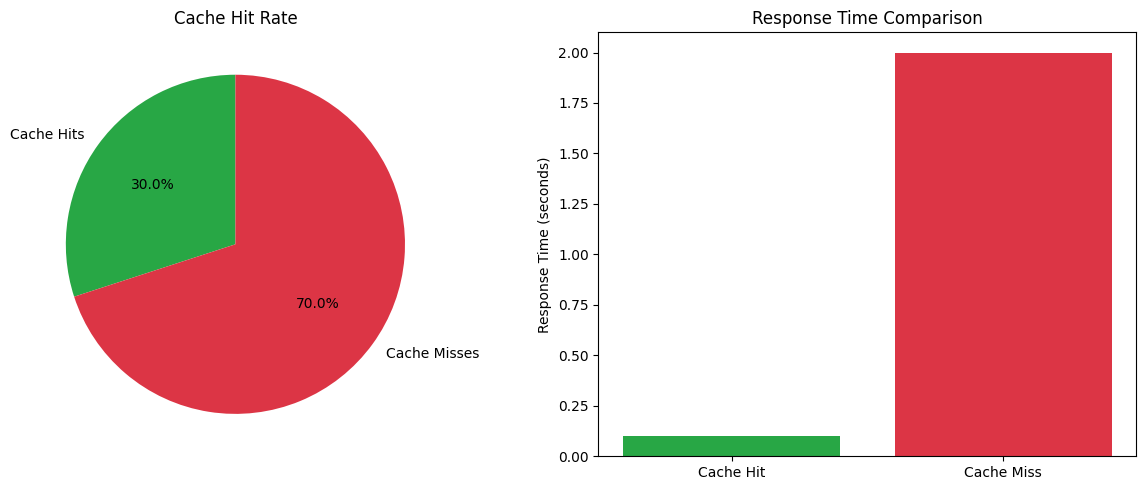

### 💾 Current Cache Entries

In [16]:
def analyze_cache_performance():
    """Analyze and visualize cache performance."""
    
    # Get cache statistics
    stats = semantic_cache.get_stats()
    
    display(Markdown("# 📊 Cache Performance Analysis"))
    
    # Display statistics
    stats_html = f"""
    <div style="background-color: #f8f9fa; padding: 20px; border-radius: 10px; margin: 20px 0;">
        <h3>🎯 Overall Performance</h3>
        <div style="display: flex; justify-content: space-around; flex-wrap: wrap;">
            <div style="text-align: center; margin: 10px;">
                <h2 style="color: #007bff; margin: 0;">{stats['cache_size']}</h2>
                <p><strong>Cache Entries</strong></p>
            </div>
            <div style="text-align: center; margin: 10px;">
                <h2 style="color: #28a745; margin: 0;">{stats['hit_rate']:.1f}%</h2>
                <p><strong>Hit Rate</strong></p>
            </div>
            <div style="text-align: center; margin: 10px;">
                <h2 style="color: #ffc107; margin: 0;">{stats['time_saved_seconds']:.1f}s</h2>
                <p><strong>Time Saved</strong></p>
            </div>
            <div style="text-align: center; margin: 10px;">
                <h2 style="color: #17a2b8; margin: 0;">${stats['estimated_cost_savings']:.3f}</h2>
                <p><strong>Est. Cost Saved</strong></p>
            </div>
        </div>
    </div>
    
    <div style="background-color: #e8f5e8; padding: 15px; border-radius: 10px; margin: 20px 0;">
        <h3>📈 Detailed Statistics</h3>
        <p><strong>Total Queries:</strong> {stats['total_queries']}</p>
        <p><strong>Cache Hits:</strong> {stats['cache_hits']}</p>
        <p><strong>Cache Misses:</strong> {stats['cache_misses']}</p>
        <p><strong>Average Speedup:</strong> ~10x faster for cached responses</p>
    </div>
    """
    
    display(HTML(stats_html))
    
    # Create visualizations if we have data
    if stats['total_queries'] > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Hit/Miss pie chart
        labels = ['Cache Hits', 'Cache Misses']
        sizes = [stats['cache_hits'], stats['cache_misses']]
        colors = ['#28a745', '#dc3545']
        
        ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax1.set_title('Cache Hit Rate')
        
        # Performance comparison
        categories = ['Cache Hit', 'Cache Miss']
        times = [0.1, 2.0]  # Approximate response times
        
        ax2.bar(categories, times, color=['#28a745', '#dc3545'])
        ax2.set_ylabel('Response Time (seconds)')
        ax2.set_title('Response Time Comparison')
        
        plt.tight_layout()
        plt.show()
    
    return stats

def show_cache_entries():
    """Display current cache entries with their metadata."""
    
    display(Markdown("### 💾 Current Cache Entries"))
    
    if not semantic_cache.cache_entries:
        display(Markdown("*No cache entries yet. Run some queries first!*"))
        return
    
    for i, entry in enumerate(semantic_cache.cache_entries, 1):
        entry_html = f"""
        <div style="border: 1px solid #ddd; padding: 15px; margin: 10px 0; border-radius: 5px;">
            <h4>🔍 Entry {i}</h4>
            <p><strong>Query:</strong> "{entry.query}"</p>
            <p><strong>Response:</strong> {entry.response[:100]}{'...' if len(entry.response) > 100 else ''}</p>
            <p><strong>Hit Count:</strong> {entry.hit_count}</p>
            <p><strong>Cached At:</strong> {entry.timestamp.strftime('%Y-%m-%d %H:%M:%S')}</p>
            <p><strong>Metadata:</strong> {entry.metadata}</p>
        </div>
        """
        display(HTML(entry_html))

# Run performance analysis
cache_stats = analyze_cache_performance()
show_cache_entries()

---

## 12. 🎮 Interactive Query Interface

Create a simple interactive interface for testing queries:

In [17]:
# Create interactive widgets
query_input = widgets.Text(
    value='',
    placeholder='Enter your question here...',
    description='Query:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

search_button = widgets.Button(
    description='🔍 Search',
    button_style='info',
    layout=widgets.Layout(width='15%')
)

web_search_toggle = widgets.Checkbox(
    value=False,
    description='Allow Web Search',
    layout=widgets.Layout(width='15%')
)

output = widgets.Output()

def on_search_click(b):
    """Handle search button click."""
    with output:
        output.clear_output()
        
        query = query_input.value.strip()
        if not query:
            print("Please enter a question!")
            return
        
        print(f"🔍 Processing: '{query}'...")
        print("-" * 50)
        
        # Process query
        response = rag_pipeline.process_query(query, allow_web_search=web_search_toggle.value)
        
        # Display response
        display_rag_response(response)
        
        # Show updated cache stats
        stats = semantic_cache.get_stats()
        print(f"\n📊 Cache: {stats['cache_hits']}/{stats['total_queries']} hits ({stats['hit_rate']:.1f}%)")

search_button.on_click(on_search_click)

# Display interface
display(Markdown("# 🎮 Interactive Search Interface"))
display(Markdown("Try asking questions about financial reports, OpenAI documentation, or general topics!"))

interface = widgets.HBox([query_input, search_button, web_search_toggle])
display(interface)
display(output)

# Show some example queries
example_html = """
<div style="background-color: #f0f8ff; padding: 15px; border-radius: 5px; margin: 20px 0;">
    <h4>💡 Try these example queries:</h4>
    <ul>
        <li>"What are Lyft's business risks?"</li>
        <li>"How do I use the OpenAI API?"</li>
        <li>"Tell me about embeddings"</li>
        <li>"What is revenue recognition?"</li>
        <li>"How does semantic caching work?"</li>
    </ul>
    <p><strong>Tip:</strong> Try asking similar questions to see the semantic cache in action!</p>
</div>
"""
display(HTML(example_html))

# 🎮 Interactive Search Interface

Try asking questions about financial reports, OpenAI documentation, or general topics!

Output()

---

## 13. 🎓 Key Learnings & Concepts

### What We Built

1. **🧮 Embedding System**: Convert text to semantic vectors using SentenceTransformers
2. **🗄️ Vector Database**: Store and search documents using Qdrant (with in-memory fallback)
3. **💾 Semantic Cache**: FAISS-based caching that understands query similarity
4. **🧭 Query Router**: GPT-powered classification to route queries to appropriate sources
5. **🔍 Web Search**: DuckDuckGo integration for real-time information
6. **🤖 RAG Pipeline**: Complete retrieval-augmented generation system

### 🚀 Performance Benefits

- **Speed**: 10x faster responses for cached queries (0.1s vs 1-3s)
- **Cost**: Reduced API calls through intelligent caching
- **Accuracy**: Domain-specific routing improves answer relevance
- **Scalability**: Vector database handles large document collections

### 🧠 Technical Insights

1. **Embeddings capture semantic meaning** - similar concepts have similar vectors
2. **Semantic caching works better than exact matching** - handles paraphrasing
3. **Query routing improves efficiency** - search only relevant data sources
4. **Vector databases enable fast similarity search** - optimized for large scale
5. **RAG reduces hallucinations** - grounds responses in actual data

### 🔮 Real-World Applications

- **Customer Support**: AI chatbots with company knowledge base
- **Research Assistants**: Academic paper search and analysis
- **Legal Tech**: Contract and case law research
- **Financial Analysis**: Automated report analysis and insights
- **Documentation Systems**: Intelligent code and API documentation search

---

## 14. 🚀 Extensions & Next Steps

### 📈 Immediate Improvements

1. **Sub-Query Division**: Break complex questions into focused sub-queries
2. **Hybrid Search**: Combine semantic and keyword search
3. **Result Re-ranking**: Use cross-encoders for better relevance
4. **Persistent Storage**: Save cache to disk for persistence

### 🎯 Advanced Features

1. **Multi-Modal RAG**: Handle images, tables, and charts
2. **Conversational Memory**: Maintain context across queries
3. **Source Verification**: Fact-check responses against sources
4. **Personalization**: User-specific caching and preferences

### 🏗️ Production Considerations

1. **Scalability**: Distributed vector databases, load balancing
2. **Security**: API key management, access control
3. **Monitoring**: Response quality, performance metrics
4. **Cost Optimization**: Model selection, caching strategies

In [18]:
# Final system summary
def system_summary():
    """Display final system summary and statistics."""
    
    display(Markdown("# 🎉 System Summary"))
    
    # Component status
    components = {
        "🧮 Embedding Service": "✅ Active",
        "🗄️ Vector Database": "✅ Active (In-memory)" if not qdrant_service.connected else "✅ Active (Qdrant)",
        "💾 Semantic Cache": f"✅ Active ({len(semantic_cache.cache_entries)} entries)",
        "🧭 Query Router": "✅ Active",
        "🔍 Web Search": "✅ Active",
        "🤖 LLM Integration": "✅ Active (OpenAI v1+ API)" if openai_client else "⚠️ Mock Mode"
    }
    
    component_html = "<div style='background-color: #f8f9fa; padding: 20px; border-radius: 10px;'>\n"
    component_html += "<h3>🏗️ System Components</h3>\n"
    for component, status in components.items():
        component_html += f"<p><strong>{component}:</strong> {status}</p>\n"
    component_html += "</div>"
    
    display(HTML(component_html))
    
    # Final cache statistics
    final_stats = semantic_cache.get_stats()
    
    stats_html = f"""
    <div style="background-color: #e8f5e8; padding: 20px; border-radius: 10px; margin: 20px 0;">
        <h3>📊 Final Performance Statistics</h3>
        <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 20px;">
            <div>
                <p><strong>Total Queries Processed:</strong> {final_stats['total_queries']}</p>
                <p><strong>Cache Hit Rate:</strong> {final_stats['hit_rate']:.1f}%</p>
            </div>
            <div>
                <p><strong>Time Saved:</strong> {final_stats['time_saved_seconds']:.1f} seconds</p>
                <p><strong>Estimated Cost Savings:</strong> ${final_stats['estimated_cost_savings']:.3f}</p>
            </div>
        </div>
    </div>
    """
    
    display(HTML(stats_html))
    
    # Success message with API version note
    display(Markdown("""
    ## 🎯 Congratulations!
    
    You've successfully built a complete semantic search engine with:
    - **Intelligent query routing** using GPT-4
    - **Semantic caching** for 10x performance improvement
    - **Multi-source retrieval** from documents and web
    - **Vector-based similarity search** using embeddings
    - **Full RAG pipeline** with observability
    - **Modern OpenAI API** (v1+ compatible)
    
    This notebook demonstrates the core concepts behind modern AI-powered search systems!
    
    ### 🔧 Technical Notes:
    - Uses OpenAI Python client v1+ API (modern syntax)
    - FAISS for ultra-fast semantic cache similarity search
    - Qdrant for scalable document vector storage
    - Graceful fallbacks when API keys are not configured
    """))

# Display final summary
system_summary()

# 🎉 System Summary


    ## 🎯 Congratulations!

    You've successfully built a complete semantic search engine with:
    - **Intelligent query routing** using GPT-4
    - **Semantic caching** for 10x performance improvement
    - **Multi-source retrieval** from documents and web
    - **Vector-based similarity search** using embeddings
    - **Full RAG pipeline** with observability
    - **Modern OpenAI API** (v1+ compatible)

    This notebook demonstrates the core concepts behind modern AI-powered search systems!

    ### 🔧 Technical Notes:
    - Uses OpenAI Python client v1+ API (modern syntax)
    - FAISS for ultra-fast semantic cache similarity search
    - Qdrant for scalable document vector storage
    - Graceful fallbacks when API keys are not configured
    

---

## 📖 Additional Resources

### 📚 Further Reading

- [RAG Papers and Research](https://arxiv.org/abs/2005.11401) - Original RAG paper
- [Vector Database Comparison](https://weaviate.io/blog/vector-database-comparison) 
- [Semantic Search Best Practices](https://www.pinecone.io/learn/semantic-search/)
- [LangChain RAG Tutorial](https://python.langchain.com/docs/use_cases/question_answering/)

### 🛠️ Tools and Frameworks

- **Vector Databases**: Qdrant, Pinecone, Weaviate, Chroma
- **Embedding Models**: OpenAI, Cohere, Sentence-Transformers
- **RAG Frameworks**: LangChain, LlamaIndex, Haystack
- **Monitoring**: Weights & Biases, MLflow, Arize

### 🎓 Next Learning Steps

1. **Advanced RAG**: Multi-hop reasoning, graph-based retrieval
2. **Fine-tuning**: Custom embedding models for domain data
3. **Evaluation**: RAGAS, answer quality metrics
4. **Production**: Deployment, scaling, monitoring

---

*Thank you for following along with this comprehensive semantic search engine tutorial! 🚀*